In [1]:
%load_ext autoreload
%autoreload 2
%cd ..
import numpy as np
import torch
import matplotlib.pyplot as plt
from modules.data import check_dict

/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [2]:
# check GPU status
!nvidia-smi

Tue Jan 21 20:23:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     Off |   00000000:83:00.0 Off |                    0 |
|  0%   22C    P8             27W /  300W |     115MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pwd

/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [4]:
# setup device
import os
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [29]:
# 1. load config
from modules.config.config import load_config_from_json
config = load_config_from_json(
    'configs/ours-train-registration.json'
    )
# config = load_config_from_json('/p/mmcardiac/Jerry/code/DENSE-guided-Cine-Registration/configs/training_configs/2023-10/2023-10-26-registraion-with-supervision-and-TOS-regression.json')

In [12]:
# 2. load all data
from modules.data import load_data
all_data = load_data(config['data'])

# append new data
from modules.data.processing.create_additional_data import create_addition_data
all_data = create_addition_data(all_data, config.get('additional_data', {}))

Found 8 npy files: 
['/scratch/jx8fh/2024-03-24-DENSE-from-Yu-SUBSET-VOL-1-OF-8.npy', '/scratch/jx8fh/2024-03-24-DENSE-from-Yu-SUBSET-VOL-2-OF-8.npy', '/scratch/jx8fh/2024-03-24-DENSE-from-Yu-SUBSET-VOL-3-OF-8.npy', '/scratch/jx8fh/2024-03-24-DENSE-from-Yu-SUBSET-VOL-4-OF-8.npy', '/scratch/jx8fh/2024-03-24-DENSE-from-Yu-SUBSET-VOL-5-OF-8.npy', '/scratch/jx8fh/2024-03-24-DENSE-from-Yu-SUBSET-VOL-6-OF-8.npy', '/scratch/jx8fh/2024-03-24-DENSE-from-Yu-SUBSET-VOL-7-OF-8.npy', '/scratch/jx8fh/2024-03-24-DENSE-from-Yu-SUBSET-VOL-8-OF-8.npy']
loading cine data from npy file...DONE!
100 slices loaded
augmenting data...Augmenting data: translate_ys=[0], translate_xs=[0], rotate_n_sectors=[]
Augmented data from 100 to 0
DONE!
<class 'list'>
len(augmented):  0
# of data after augmentation: 100
loading cine data from npy file...DONE!
100 slices loaded
augmenting data...Augmenting data: translate_ys=[0], translate_xs=[0], rotate_n_sectors=[]
Augmented data from 100 to 0
DONE!
<class 'list'>
len(augm

In [15]:


train_split = {
    'info': {},
    'data': [d for d in all_data if d['subject_id'].replace('-DENSE', '').replace('-Cine', '') not in config['data_split']['splits']['train']['exclude_patterns']]
}
val_split = {
    'info': {},
    'data': [d for d in all_data if d['subject_id'].replace('-DENSE', '').replace('-Cine', '') in config['data_split']['splits']['val']['patterns']]
}
test_split = {
    'info': {},
    'data': [d for d in all_data if d['subject_id'].replace('-DENSE', '').replace('-Cine', '') in config['data_split']['splits']['test']['patterns']]
}
data_splits = {
    'train': train_split,
    'val': val_split,
    'test': test_split
}
for split_name, split in data_splits.items():
    print(split_name, len(split['data']))

# 4. Building dataset
from modules.data.dataset import build_datasets
datasets = build_datasets(config['datasets'], data_splits)

train 753
val 122
test 137
Using Lagrangian displacement field
Using Lagrangian displacement field
Using Lagrangian displacement field


In [16]:
len(train_split['data'])

753

In [17]:
# 6. Building model
from models import build_model
networks = {}
for model_name, model_config in config['networks'].items():
    networks[model_name] = build_model(model_config)
    networks[model_name] = networks[model_name].to( device)
# model = build_model(config['network'])

Skip connect: False
Loading pretrained model from checkpoints/ours_registration.pth


In [18]:
networks['registration'].disp_generator

'Epdiff'

In [19]:
# import torch.nn as nn
# networks['registration'].register_unet.conv_mu = nn.Conv3d(32, 32, kernel_size=3, padding=1, device=device)
# networks['registration'].register_unet.conv_log_var = nn.Conv3d(32, 32, kernel_size=3, padding=1, device=device)

In [20]:
# trainer.optimizers['registration']

In [31]:
# Training
from modules.trainer import build_trainer
config['training']['epochs'] = 30 # set only 30 epochs for debugging
config['training']['batch_size'] = 64
config['training']['learning_rate'] = 1e-4
trainer = build_trainer(config['training'], device, config)

In [32]:
config['training']

{'seed': 2434,
 'scheme': 'registration',
 'batch_forward_method': 'reg_disp_pred',
 'reg_forward_data': 'latent',
 'regression_output_type': 'disp',
 'mask_padded_frames': True,
 'resize_before_regression': False,
 'batch_size': 64,
 'epochs': 30,
 'enable_random_rotate': False,
 'random_rotate_prob_thres': 0.3,
 'epochs_without_improvement_tolerance': 30,
 'disp_masking': True,
 'disp_mask_key': 'src_tar_disp_union_mask',
 'save_best_model_interval': -1,
 'training_latent_model_epoch_interval': 30,
 'training_motion_decoder_epoch_interval': 30,
 'optimization': {'registration': {'type': 'Adam',
   'target': 'registration',
   'weight_decay': 1e-05,
   'learning_rate': 0.0001,
   'lr_scheduler': {'enable': True,
    'type': 'StepLR',
    'step_size': 15,
    'gamma': 0.9}}},
 'learning_rate': 0.0001}

In [33]:
exp_dict, trained_models, wandb_experiment = trainer.train(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    use_tensorboard=False,
    tensorboard_log_dir='tensorboard',
    use_wandb=False)

registration lr_scheduler: <torch.optim.lr_scheduler.StepLR object at 0x7fbbdd384b80>


32it [00:43,  1.36s/it]00:00<?, ?it/s]
6it [00:02,  2.13it/s].765e+00:   0%|          | 0/30 [00:43<?, ?it/s]
Epoch 0 | Train Loss 2.765e+00:   3%|▎         | 1/30 [00:46<22:34, 46.70s/it]

{
    "train/registration_reconstruction": 2.738288566470146,
    "train/total_loss": 2.74046740781705,
    "train/reconstruction_error": 0.002178841346903937,
    "val/registration_reconstruction": 2.6142635345458984,
    "val/total_loss": 2.6163670455959314,
    "val/reconstruction_error": 0.0021035110500330725
}


32it [00:33,  1.06s/it]
6it [00:03,  1.85it/s].464e+00:   3%|▎         | 1/30 [01:21<22:34, 46.70s/it]
Epoch 1 | Train Loss 2.464e+00:   7%|▋         | 2/30 [01:24<19:18, 41.37s/it]

{
    "train/registration_reconstruction": 2.6811663657426834,
    "train/total_loss": 2.6832291978607827,
    "train/reconstruction_error": 0.0020628321180993225,
    "val/registration_reconstruction": 2.6031867265701294,
    "val/total_loss": 2.6052608765506498,
    "val/reconstruction_error": 0.002074149980520209
}


32it [00:33,  1.06s/it]
6it [00:02,  2.26it/s].944e+00:   7%|▋         | 2/30 [01:58<19:18, 41.37s/it]
Epoch 2 | Train Loss 2.944e+00:  10%|█         | 3/30 [02:01<17:43, 39.38s/it]

{
    "train/registration_reconstruction": 2.6797156557440758,
    "train/total_loss": 2.6817686199428863,
    "train/reconstruction_error": 0.002052964198810514,
    "val/registration_reconstruction": 2.60016667842865,
    "val/total_loss": 2.6022254647881105,
    "val/reconstruction_error": 0.0020587863594604037
}


32it [00:34,  1.09s/it]
6it [00:02,  2.26it/s].778e+00:  10%|█         | 3/30 [02:36<17:43, 39.38s/it]
Epoch 3 | Train Loss 2.778e+00:  13%|█▎        | 4/30 [02:39<16:50, 38.86s/it]

{
    "train/registration_reconstruction": 2.678506076335907,
    "train/total_loss": 2.680555659288075,
    "train/reconstruction_error": 0.002049582952167839,
    "val/registration_reconstruction": 2.602875749270121,
    "val/total_loss": 2.604964960288877,
    "val/reconstruction_error": 0.002089211018756032
}
Epochs without improvement: 1 / 30


32it [00:33,  1.06s/it]
6it [00:02,  2.25it/s].932e+00:  13%|█▎        | 4/30 [03:13<16:50, 38.86s/it]
Epoch 4 | Train Loss 2.932e+00:  17%|█▋        | 5/30 [03:16<15:55, 38.21s/it]

{
    "train/registration_reconstruction": 2.6775502115488052,
    "train/total_loss": 2.679596504098299,
    "train/reconstruction_error": 0.0020462925494939554,
    "val/registration_reconstruction": 2.6024163961410522,
    "val/total_loss": 2.6044700743514113,
    "val/reconstruction_error": 0.0020536782103590667
}
Epochs without improvement: 2 / 30


32it [00:33,  1.06s/it]
6it [00:02,  2.24it/s].829e+00:  17%|█▋        | 5/30 [03:50<15:55, 38.21s/it]
Epoch 5 | Train Loss 2.829e+00:  20%|██        | 6/30 [03:53<15:07, 37.80s/it]

{
    "train/registration_reconstruction": 2.676786608994007,
    "train/total_loss": 2.678830391356314,
    "train/reconstruction_error": 0.002043782362306956,
    "val/registration_reconstruction": 2.6042540868123374,
    "val/total_loss": 2.6063432881298163,
    "val/reconstruction_error": 0.0020892013174792132
}
Epochs without improvement: 3 / 30


32it [00:38,  1.21s/it]
6it [00:03,  1.94it/s].750e+00:  20%|██        | 6/30 [04:32<15:07, 37.80s/it]
Epoch 6 | Train Loss 2.750e+00:  23%|██▎       | 7/30 [04:35<15:03, 39.28s/it]

{
    "train/registration_reconstruction": 2.67626129090786,
    "train/total_loss": 2.6783040464506485,
    "train/reconstruction_error": 0.0020427555427886546,
    "val/registration_reconstruction": 2.5953692197799683,
    "val/total_loss": 2.597415564581752,
    "val/reconstruction_error": 0.0020463448017835617
}


32it [00:35,  1.10s/it]
6it [00:02,  2.24it/s].529e+00:  23%|██▎       | 7/30 [05:11<15:03, 39.28s/it]
Epoch 7 | Train Loss 2.529e+00:  27%|██▋       | 8/30 [05:14<14:17, 38.97s/it]

{
    "train/registration_reconstruction": 2.6713025122880936,
    "train/total_loss": 2.673338286782382,
    "train/reconstruction_error": 0.0020357744942884892,
    "val/registration_reconstruction": 2.595256527264913,
    "val/total_loss": 2.5972832685414082,
    "val/reconstruction_error": 0.0020267412764951587
}


32it [00:34,  1.07s/it]
6it [00:02,  2.25it/s].046e+00:  27%|██▋       | 8/30 [05:48<14:17, 38.97s/it]
Epoch 8 | Train Loss 3.046e+00:  30%|███       | 9/30 [05:51<13:28, 38.48s/it]

{
    "train/registration_reconstruction": 2.6731688752770424,
    "train/total_loss": 2.675201776648464,
    "train/reconstruction_error": 0.002032901371421758,
    "val/registration_reconstruction": 2.597216844558716,
    "val/total_loss": 2.5992667086732886,
    "val/reconstruction_error": 0.0020498641145726046
}
Epochs without improvement: 1 / 30


32it [00:35,  1.10s/it]
6it [00:02,  2.25it/s].785e+00:  30%|███       | 9/30 [06:27<13:28, 38.48s/it]
Epoch 9 | Train Loss 2.785e+00:  33%|███▎      | 10/30 [06:29<12:48, 38.43s/it]

{
    "train/registration_reconstruction": 2.671381250023842,
    "train/total_loss": 2.6734161536187457,
    "train/reconstruction_error": 0.0020349035949038807,
    "val/registration_reconstruction": 2.5952888329823813,
    "val/total_loss": 2.5973172440814474,
    "val/reconstruction_error": 0.002028411099066337
}
Epochs without improvement: 2 / 30


32it [00:34,  1.07s/it]
6it [00:02,  2.20it/s]2.569e+00:  33%|███▎      | 10/30 [07:04<12:48, 38.43s/it]
Epoch 10 | Train Loss 2.569e+00:  37%|███▋      | 11/30 [07:07<12:05, 38.17s/it]

{
    "train/registration_reconstruction": 2.6686532869935036,
    "train/total_loss": 2.67068080566969,
    "train/reconstruction_error": 0.002027518676186446,
    "val/registration_reconstruction": 2.5932836532592773,
    "val/total_loss": 2.5953323037247173,
    "val/reconstruction_error": 0.002048650465440005
}


32it [00:36,  1.15s/it]
6it [00:02,  2.23it/s]2.527e+00:  37%|███▋      | 11/30 [07:44<12:05, 38.17s/it]
Epoch 11 | Train Loss 2.527e+00:  40%|████      | 12/30 [07:47<11:37, 38.73s/it]

{
    "train/registration_reconstruction": 2.6683597564697266,
    "train/total_loss": 2.6703884798080253,
    "train/reconstruction_error": 0.0020287233382987324,
    "val/registration_reconstruction": 2.5908701419830322,
    "val/total_loss": 2.592913357211122,
    "val/reconstruction_error": 0.002043215228089442
}


32it [00:35,  1.11s/it]
6it [00:02,  2.07it/s]2.926e+00:  40%|████      | 12/30 [08:23<11:37, 38.73s/it]
Epoch 12 | Train Loss 2.926e+00:  43%|████▎     | 13/30 [08:26<10:59, 38.82s/it]

{
    "train/registration_reconstruction": 2.6709878966212273,
    "train/total_loss": 2.6730177440585976,
    "train/reconstruction_error": 0.0020298474373703357,
    "val/registration_reconstruction": 2.5897899866104126,
    "val/total_loss": 2.591816276020836,
    "val/reconstruction_error": 0.0020262894104234874
}


32it [00:35,  1.10s/it]
6it [00:02,  2.26it/s]2.601e+00:  43%|████▎     | 13/30 [09:02<10:59, 38.82s/it]
Epoch 13 | Train Loss 2.601e+00:  47%|████▋     | 14/30 [09:04<10:19, 38.72s/it]

{
    "train/registration_reconstruction": 2.6668978929519653,
    "train/total_loss": 2.6689232849712425,
    "train/reconstruction_error": 0.0020253920192772057,
    "val/registration_reconstruction": 2.590135097503662,
    "val/total_loss": 2.592157695966307,
    "val/reconstruction_error": 0.0020225984626449645
}
Epochs without improvement: 1 / 30


32it [00:34,  1.07s/it]
6it [00:02,  2.25it/s]2.560e+00:  47%|████▋     | 14/30 [09:39<10:19, 38.72s/it]
Epoch 14 | Train Loss 2.560e+00:  50%|█████     | 15/30 [09:42<09:34, 38.30s/it]

{
    "train/registration_reconstruction": 2.6699659526348114,
    "train/total_loss": 2.671995248991152,
    "train/reconstruction_error": 0.0020292963563406374,
    "val/registration_reconstruction": 2.593379855155945,
    "val/total_loss": 2.5954163615824655,
    "val/reconstruction_error": 0.0020365064265206456
}
Epochs without improvement: 2 / 30


32it [00:33,  1.06s/it]
6it [00:02,  2.28it/s]2.777e+00:  50%|█████     | 15/30 [10:16<09:34, 38.30s/it]
Epoch 15 | Train Loss 2.777e+00:  53%|█████▎    | 16/30 [10:19<08:50, 37.91s/it]

{
    "train/registration_reconstruction": 2.667474217712879,
    "train/total_loss": 2.669503984558105,
    "train/reconstruction_error": 0.002029766845225822,
    "val/registration_reconstruction": 2.588585058848063,
    "val/total_loss": 2.5906301917081387,
    "val/reconstruction_error": 0.0020451328600756824
}


32it [00:33,  1.06s/it]
6it [00:02,  2.26it/s]2.639e+00:  53%|█████▎    | 16/30 [10:53<08:50, 37.91s/it]
Epoch 16 | Train Loss 2.639e+00:  57%|█████▋    | 17/30 [10:56<08:09, 37.65s/it]

{
    "train/registration_reconstruction": 2.6645344123244286,
    "train/total_loss": 2.6665541336260503,
    "train/reconstruction_error": 0.0020197213016217574,
    "val/registration_reconstruction": 2.5932045777638755,
    "val/total_loss": 2.59522720957951,
    "val/reconstruction_error": 0.002022631815634668
}
Epochs without improvement: 1 / 30


32it [00:33,  1.06s/it]
6it [00:02,  2.28it/s]2.610e+00:  57%|█████▋    | 17/30 [11:30<08:09, 37.65s/it]
Epoch 17 | Train Loss 2.610e+00:  60%|██████    | 18/30 [11:33<07:29, 37.45s/it]

{
    "train/registration_reconstruction": 2.665840581059456,
    "train/total_loss": 2.6678632841540093,
    "train/reconstruction_error": 0.0020227030945534352,
    "val/registration_reconstruction": 2.590936223665873,
    "val/total_loss": 2.5929776522680186,
    "val/reconstruction_error": 0.002041428602145364
}
Epochs without improvement: 2 / 30


32it [00:33,  1.06s/it]
6it [00:02,  2.28it/s]2.857e+00:  60%|██████    | 18/30 [12:07<07:29, 37.45s/it]
Epoch 18 | Train Loss 2.857e+00:  63%|██████▎   | 19/30 [12:10<06:50, 37.31s/it]

{
    "train/registration_reconstruction": 2.6654307544231415,
    "train/total_loss": 2.6674534208941623,
    "train/reconstruction_error": 0.0020226664710207842,
    "val/registration_reconstruction": 2.590894103050232,
    "val/total_loss": 2.592944161442574,
    "val/reconstruction_error": 0.00205005839234218
}
Epochs without improvement: 3 / 30


32it [00:33,  1.06s/it]
6it [00:02,  2.28it/s]2.668e+00:  63%|██████▎   | 19/30 [12:44<06:50, 37.31s/it]
Epoch 19 | Train Loss 2.668e+00:  67%|██████▋   | 20/30 [12:47<06:12, 37.23s/it]

{
    "train/registration_reconstruction": 2.662698484957218,
    "train/total_loss": 2.6647176867627422,
    "train/reconstruction_error": 0.0020192018055240624,
    "val/registration_reconstruction": 2.5868406295776367,
    "val/total_loss": 2.588872770856445,
    "val/reconstruction_error": 0.0020321412788083157
}


32it [00:34,  1.08s/it]
6it [00:02,  2.26it/s]2.922e+00:  67%|██████▋   | 20/30 [13:22<06:12, 37.23s/it]
Epoch 20 | Train Loss 2.922e+00:  70%|███████   | 21/30 [13:25<05:36, 37.38s/it]

{
    "train/registration_reconstruction": 2.66415536403656,
    "train/total_loss": 2.6661723379438627,
    "train/reconstruction_error": 0.0020169739073025994,
    "val/registration_reconstruction": 2.5884016354878745,
    "val/total_loss": 2.5904338390100747,
    "val/reconstruction_error": 0.0020322035222003856
}
Epochs without improvement: 1 / 30


32it [00:37,  1.18s/it]
6it [00:02,  2.27it/s]2.722e+00:  70%|███████   | 21/30 [14:03<05:36, 37.38s/it]
Epoch 21 | Train Loss 2.722e+00:  73%|███████▎  | 22/30 [14:05<05:07, 38.44s/it]

{
    "train/registration_reconstruction": 2.6628810837864876,
    "train/total_loss": 2.6648970124260813,
    "train/reconstruction_error": 0.002015928639593767,
    "val/registration_reconstruction": 2.584416151046753,
    "val/total_loss": 2.5864376885971674,
    "val/reconstruction_error": 0.002021537550414602
}


32it [00:34,  1.07s/it]
6it [00:02,  2.24it/s]2.905e+00:  73%|███████▎  | 22/30 [14:40<05:07, 38.44s/it]
Epoch 22 | Train Loss 2.905e+00:  77%|███████▋  | 23/30 [14:43<04:27, 38.15s/it]

{
    "train/registration_reconstruction": 2.665385328233242,
    "train/total_loss": 2.667406040662172,
    "train/reconstruction_error": 0.0020207124289299827,
    "val/registration_reconstruction": 2.588555693626404,
    "val/total_loss": 2.5905618951073848,
    "val/reconstruction_error": 0.0020062014809809625
}
Epochs without improvement: 1 / 30


32it [00:33,  1.06s/it]
6it [00:02,  2.28it/s]2.790e+00:  77%|███████▋  | 23/30 [15:17<04:27, 38.15s/it]
Epoch 23 | Train Loss 2.790e+00:  80%|████████  | 24/30 [15:20<03:46, 37.81s/it]

{
    "train/registration_reconstruction": 2.6626712903380394,
    "train/total_loss": 2.6646858339627215,
    "train/reconstruction_error": 0.002014543624682119,
    "val/registration_reconstruction": 2.5852624972661338,
    "val/total_loss": 2.587302856244302,
    "val/reconstruction_error": 0.002040358978168418
}
Epochs without improvement: 2 / 30


32it [00:34,  1.08s/it]
6it [00:04,  1.26it/s]2.815e+00:  80%|████████  | 24/30 [15:55<03:46, 37.81s/it]
Epoch 24 | Train Loss 2.815e+00:  83%|████████▎ | 25/30 [16:00<03:12, 38.42s/it]

{
    "train/registration_reconstruction": 2.661159008741379,
    "train/total_loss": 2.663171549964318,
    "train/reconstruction_error": 0.002012541222939035,
    "val/registration_reconstruction": 2.586979071299235,
    "val/total_loss": 2.5890028085171557,
    "val/reconstruction_error": 0.0020237372179205218
}
Epochs without improvement: 3 / 30


32it [00:34,  1.09s/it]
6it [00:02,  2.25it/s]2.969e+00:  83%|████████▎ | 25/30 [16:35<03:12, 38.42s/it]
Epoch 25 | Train Loss 2.969e+00:  87%|████████▋ | 26/30 [16:38<02:33, 38.28s/it]

{
    "train/registration_reconstruction": 2.6614184081554413,
    "train/total_loss": 2.6634283875246183,
    "train/reconstruction_error": 0.0020099793691770174,
    "val/registration_reconstruction": 2.585479736328125,
    "val/total_loss": 2.5874992365327976,
    "val/reconstruction_error": 0.002019500204672416
}
Epochs without improvement: 4 / 30


32it [00:33,  1.06s/it]
6it [00:02,  2.16it/s]2.557e+00:  87%|████████▋ | 26/30 [17:12<02:33, 38.28s/it]
Epoch 26 | Train Loss 2.557e+00:  90%|█████████ | 27/30 [17:15<01:53, 37.94s/it]

{
    "train/registration_reconstruction": 2.661107189953327,
    "train/total_loss": 2.6631231627761736,
    "train/reconstruction_error": 0.002015972822846379,
    "val/registration_reconstruction": 2.5878207683563232,
    "val/total_loss": 2.589827880845405,
    "val/reconstruction_error": 0.002007112489081919
}
Epochs without improvement: 5 / 30


32it [00:33,  1.06s/it]
6it [00:02,  2.28it/s]2.612e+00:  90%|█████████ | 27/30 [17:49<01:53, 37.94s/it]
Epoch 27 | Train Loss 2.612e+00:  93%|█████████▎| 28/30 [17:52<01:15, 37.68s/it]

{
    "train/registration_reconstruction": 2.664243370294571,
    "train/total_loss": 2.6662632334409864,
    "train/reconstruction_error": 0.002019863146415446,
    "val/registration_reconstruction": 2.594800074895223,
    "val/total_loss": 2.5968736991247474,
    "val/reconstruction_error": 0.0020736242295242846
}
Epochs without improvement: 6 / 30


32it [00:33,  1.06s/it]
6it [00:02,  2.27it/s]2.842e+00:  93%|█████████▎| 28/30 [18:26<01:15, 37.68s/it]
Epoch 28 | Train Loss 2.842e+00:  97%|█████████▋| 29/30 [18:29<00:37, 37.49s/it]

{
    "train/registration_reconstruction": 2.6787624433636665,
    "train/total_loss": 2.6808096727036173,
    "train/reconstruction_error": 0.002047229339950718,
    "val/registration_reconstruction": 2.5872617959976196,
    "val/total_loss": 2.589304517644147,
    "val/reconstruction_error": 0.002042721646527449
}
Epochs without improvement: 7 / 30


32it [00:36,  1.13s/it]
6it [00:02,  2.27it/s]2.597e+00:  97%|█████████▋| 29/30 [19:06<00:37, 37.49s/it]
Epoch 29 | Train Loss 2.597e+00: 100%|██████████| 30/30 [19:08<00:00, 38.29s/it]

{
    "train/registration_reconstruction": 2.659879542887211,
    "train/total_loss": 2.661894244087307,
    "train/reconstruction_error": 0.0020147012000961695,
    "val/registration_reconstruction": 2.584269324938456,
    "val/total_loss": 2.586300439822177,
    "val/reconstruction_error": 0.002031114883720875
}


In [61]:
# # save model and config
# from pathlib import Path
# from datetime import datetime
# save_dir = Path('/p/mmcardiac/Jerry/code/CINE-DENSE-Translation/notebooks/2024-03/2024-03-11-train-SVF-registration')
# model_save_filename = f'regSVF.pth'
# save_dir.mkdir(parents=True, exist_ok=True)
# torch.save(trained_models['registration'].state_dict(), save_dir / model_save_filename)
# # save config
# import json
# with open(save_dir / 'config.json', 'w') as f:
#     json.dump(config, f, indent=4)

In [34]:
# generate training set prediction
train_pred, train_performance_dict, _ = trainer.test(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    target_dataset='train',
    mode='test')

test_loss_dict:  {'train/registration_reconstruction': 2.6566591784358025, 'train/total_loss': 2.65867211161094, 'train/reconstruction_error': 0.002012933175137732}


In [56]:
# test model
# val_pred, val_performance_dict, _ = trainer.test(
#     models=networks, 
#     datasets=datasets, 
#     trainer_config=config['training'], 
#     full_config=config, 
#     device=device,
#     target_dataset='val',
#     mode='test')

In [35]:
# test model
test_pred, test_performance_dict, _ = trainer.test(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    target_dataset='test',
    mode='test')

test_loss_dict:  {'test/registration_reconstruction': 2.8890845435006276, 'test/total_loss': 2.8912032040368234, 'test/reconstruction_error': 0.0021186605361955507}


In [53]:
check_dict(test_pred[0])

displacement_pred                                            (2, 16, 128, 128)   
velocity_pred                                                (2, 16, 128, 128)   
momentum_pred                                                (2, 16, 128, 128)   
deformed_source_pred                                         (1, 16, 128, 128)   
latent_pred                                                  (16, 16, 16, 16)    
src                                                          (1, 16, 128, 128)   
tar                                                          (1, 16, 128, 128)   
augmented                                                    False               
DENSE_slice_mat_filename                                     /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/16_ROI.1.mat
DENSE_slice_location                                         -49.126999796219    
subject_id                                                   16-DENSE            
slice_idx                               

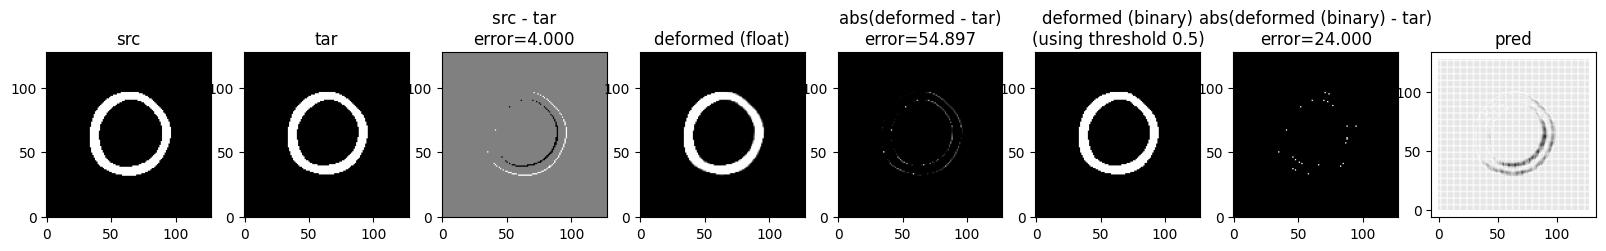

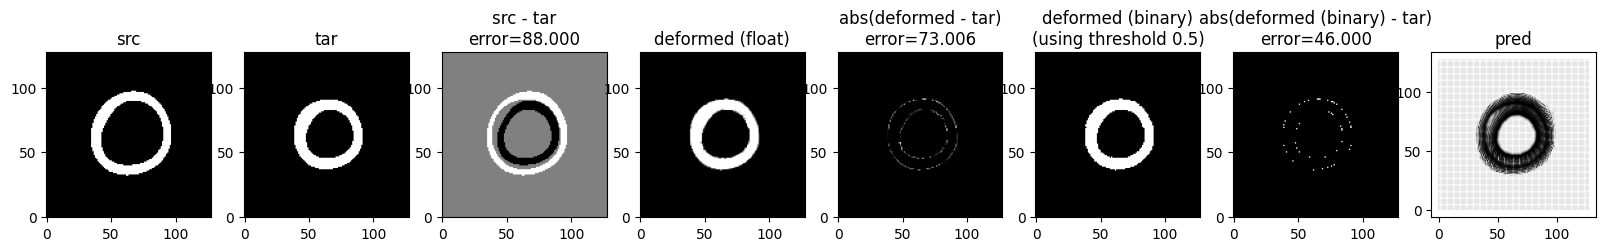

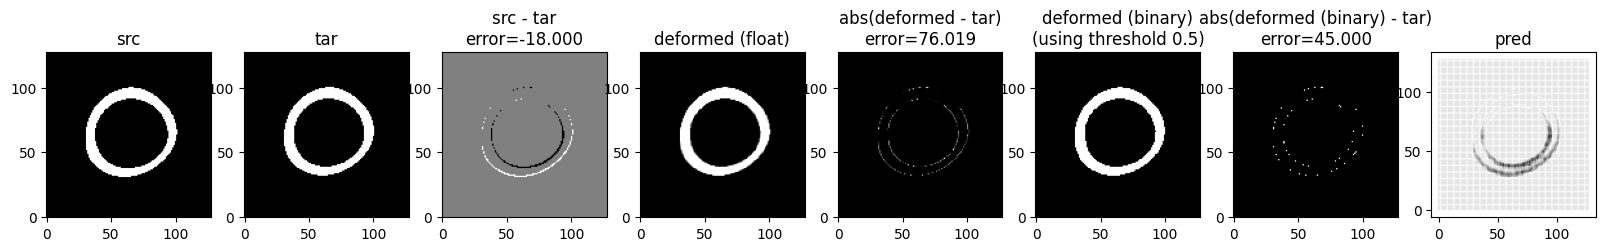

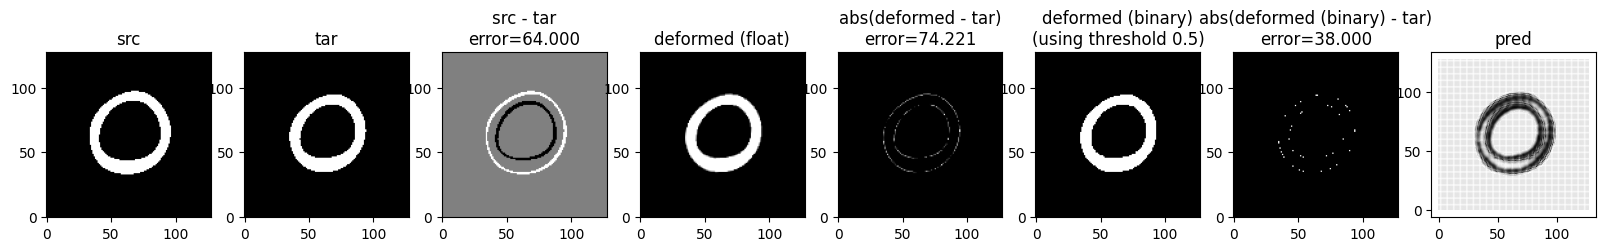

In [63]:
# check the source, target, abs(source- target), deformed, abs(deformed - target), pred disp, DENSE disp
import numpy as np
import matplotlib.pyplot as plt
for check_pair_idx in [0,5,10,20]:
    src = train_pred[check_pair_idx]['src'][0].astype(float)[0]
    tar = train_pred[check_pair_idx]['tar'][0].astype(float)[0]
    src_tar_diff = src - tar
    deformed = train_pred[check_pair_idx]['deformed_source_pred'][0][0]
    deformed_tar_diff = np.abs(deformed - tar)
    deformed_bin = deformed > 0.5
    deformed_bin_tar_diff = np.abs(deformed_bin - tar)
    disp_pred = train_pred[check_pair_idx]['displacement_pred'][:, 0]
    # disp_DENSE = test_pred[check_pair_idx]['DENSE_disp']

    fig, axs = plt.subplots(1, 8, figsize=(20, 5))
    axs[0].imshow(src, cmap='gray')
    axs[0].set_title('src')
    axs[1].imshow(tar, cmap='gray')
    axs[1].set_title('tar')
    axs[2].imshow(src_tar_diff, cmap='gray')
    axs[2].set_title(f'src - tar\nerror={src_tar_diff.sum():.3f}')

    axs[3].imshow(deformed, cmap='gray')
    axs[3].set_title('deformed (float)')
    axs[4].imshow(deformed_tar_diff, cmap='gray')
    axs[4].set_title(f'abs(deformed - tar)\nerror={deformed_tar_diff.sum():.3f}')

    axs[5].imshow(deformed_bin, cmap='gray')
    axs[5].set_title('deformed (binary)\n(using threshold 0.5)')
    axs[6].imshow(deformed_bin_tar_diff, cmap='gray')
    axs[6].set_title(f'abs(deformed (binary) - tar)\nerror={deformed_bin_tar_diff.sum():.3f}')

    axs[7].quiver(disp_pred[0], disp_pred[1], scale=1, units='xy')
    # axs[7].invert_yaxis()
    axs[7].set_title('pred')
    axs[7].set_aspect('equal')
    # axs[6].quiver(disp_DENSE[0], disp_DENSE[1], scale=10)
    # axs[6].set_title('DENSE')
    # axs[6].set_aspect('equal')

    for axs_idx in range(7):
        # invert the y axis of the imshow results to match the quiver result
        axs[axs_idx].invert_yaxis()

    # save figure
    # fig.savefig(save_exp_dir / f'check_pair_train_{check_pair_idx}.png', bbox_inches='tight')


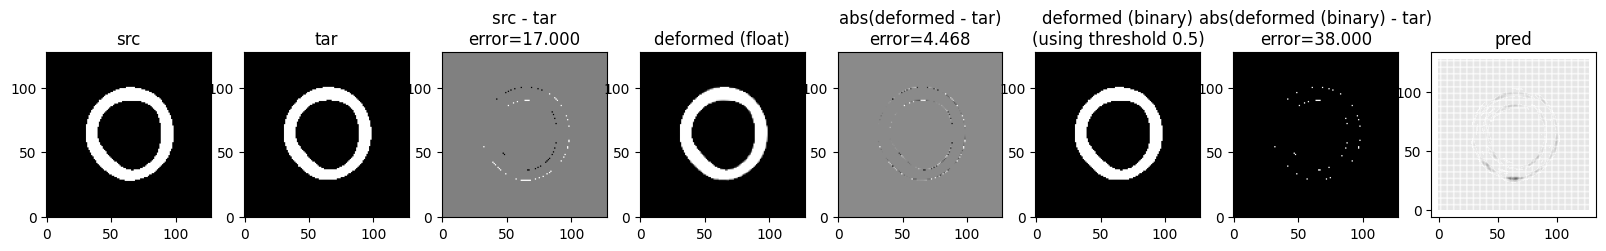

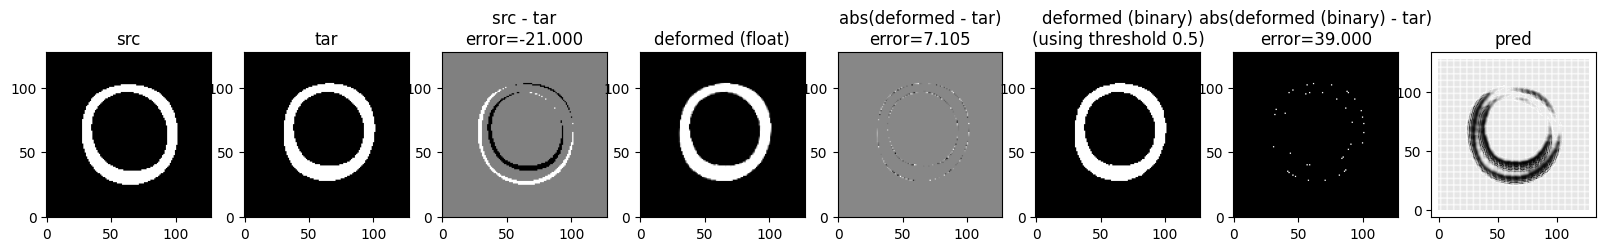

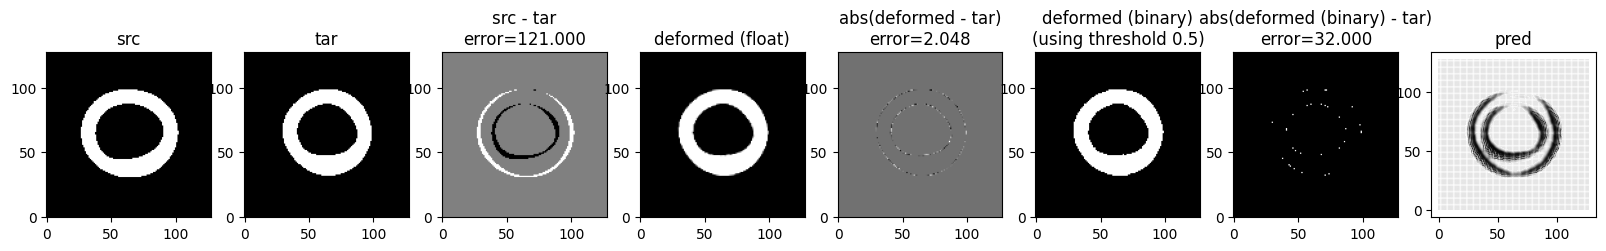

In [61]:
# check the source, target, abs(source- target), deformed, abs(deformed - target), pred disp, DENSE disp
import numpy as np
import matplotlib.pyplot as plt
# for check_pair_idx in [0,5,10,20]:
# for check_pair_idx in [22, 32, 45, 60]:
for check_pair_idx in [22, 32, 45]:
    src = test_pred[check_pair_idx]['src'][0].astype(float)[0]
    tar = test_pred[check_pair_idx]['tar'][0].astype(float)[0]
    # src_tar_diff = np.abs(src - tar)
    src_tar_diff = src - tar
    deformed = test_pred[check_pair_idx]['deformed_source_pred'][0][0]
    # deformed_tar_diff = np.abs(deformed - tar)
    deformed_tar_diff = deformed - tar
    deformed_bin = deformed > 0.5
    deformed_bin_tar_diff = np.abs(deformed_bin - tar)
    disp_pred = test_pred[check_pair_idx]['displacement_pred'][:, 0]
    # disp_DENSE = test_pred[check_pair_idx]['DENSE_disp']

    fig, axs = plt.subplots(1, 8, figsize=(20, 5))
    axs[0].imshow(src, cmap='gray')
    axs[0].set_title('src')
    axs[1].imshow(tar, cmap='gray')
    axs[1].set_title('tar')
    axs[2].imshow(src_tar_diff, cmap='gray')
    axs[2].set_title(f'src - tar\nerror={src_tar_diff.sum():.3f}')

    axs[3].imshow(deformed, cmap='gray')
    axs[3].set_title('deformed (float)')
    axs[4].imshow(deformed_tar_diff, cmap='gray')
    axs[4].set_title(f'abs(deformed - tar)\nerror={deformed_tar_diff.sum():.3f}')

    axs[5].imshow(deformed_bin, cmap='gray')
    axs[5].set_title('deformed (binary)\n(using threshold 0.5)')
    axs[6].imshow(deformed_bin_tar_diff, cmap='gray')
    axs[6].set_title(f'abs(deformed (binary) - tar)\nerror={deformed_bin_tar_diff.sum():.3f}')

    axs[7].quiver(disp_pred[0], disp_pred[1], scale=1, units='xy')
    # axs[7].invert_yaxis()
    axs[7].set_title('pred')
    axs[7].set_aspect('equal')

    for axs_idx in range(7):
        # invert the y axis of the imshow results to match the quiver result
        axs[axs_idx].invert_yaxis()
    # axs[6].quiver(disp_DENSE[0], disp_DENSE[1], scale=10)
    # axs[6].set_title('DENSE')
    # axs[6].set_aspect('equal')
    
    # save figure
    # fig.savefig(save_exp_dir / f'check_pair_test_{check_pair_idx}.png', bbox_inches='tight')
